In [ ]:
%pip install transformers

In [ ]:
%pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=b7a7624e9e48f856892d6073f7936799c379a856a355c9eb477e0c72c5a94fe4
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [1]:
import json
import pickle
import time
import datetime
import random
import os
import csv

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import torch
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from seqeval.metrics import f1_score

import matplotlib.pyplot as plt

device = torch.device("cpu")

SEED_VAL = 42

random.seed(SEED_VAL)
np.random.seed(SEED_VAL)
torch.manual_seed(SEED_VAL);  # Semicolon prevents jupyter from displaying last line as output

In [ ]:
from google.colab import drive

drive.mount('/content/drive/')


Mounted at /content/drive/


# Intent Recognition

Voice user interfaces (e.g. Amazon Alexa, chatbots, and social robots) are becoming an essential part of everyday life. For these systems to carry out effective dialogue, they must be able to determine the intent behind a user’s spoken utterance. Intent recognition is the task of taking a written or spoken input, and determining which of several classes it matches in order to best respond or guide the interaction. Effective intent recognition is essential to building many kinds of conversational technologies, from chatbots, to automated phone systems, to social robots. In this notebook, you'll train an intent recognition model, and will explore how the amount of training data used effects performance.

## The Snips Dataset

For our intent recognition model, we'll use the Snips dataset, which was collected through crowdsourcing for the Snips personal voice assistant. There are 7 unique intent classes for the training set, on a variety of topics including playing music, restaurant reservations, and getting the weather (e.g. ‘Book an Italian place with a parking for my grand father and I’ and ‘Which movie theater is playing The Good Will Hunting nearby?’). The training set contains 13,084 utterances, and separate validation and test sets that contain 700 utterances each.

## Multi-Class Classification Models

Until now, our models have outputted a single number, representing the binary classification tasks of action item vs. non-action item, and positive sentiment vs. negative sentiment. In this case, our model needs to choose between one of several possible intent labels – to do this, it will output a vector instead of a single value.

For example, imagine a scenario where we have three intent classes for a very simple music player: "Play" (intent \#0), "Pause" (intent \#1), and "Next Song" (intent \#2). Given the input "start playing", our model might output the following vector:

$$\begin{vmatrix}
0.61 \\
0.05 \\
0.34
\end{vmatrix}$$

In our ouput vector, the $i_{th}$ entry represents the predicted probability that the input matches the $i_{th}$ intent, so here our model correctly predicts "Play". In order to convert the output vector to a vector of probabilities, the **[softmax function](https://en.wikipedia.org/wiki/Softmax_function)** is used. Without softmax, a multi-class classification model will simply return a vector of numbers, with the greatest number in the entry that represents the best intent guess, the second greatest entry the second best intent guess, etc. These raw output values are called **logits**.

To calculate the loss between our model's predictions and the correct output labels, we'll use **cross-entropy loss**. Cross entropy is essentially a comparison of how similar two probability distributions are, and in our case, we will compare the model's predicted probabilities of each label against the target vector where the probability of the true intent is 1, and all other intents have zero probability. [You can read about cross entropy in more detail here.](https://machinelearningmastery.com/cross-entropy-for-machine-learning/).


## BERT

For our intent recognition model, we'll use **BERT**, which is a **transformer**-based model that has been **pre-trained** on an enormous amount of English data. Through this pre-training, BERT learns to represent language very effectively, and can then be **fine-tuned** for a specific task. In our previous notebooks, we trained entire models end-to-end starting from random model weights, but with BERT, we will start with the pre-trained weights, and then do additional training to adapt BERT to our intent recognition task.

To learn about BERT in more detail, you should watch this [video](https://www.youtube.com/watch?v=xI0HHN5XKDo). Don't worry if BERT's architecture feels too complex, the key things to takeaway are how it is pre-trained, and how we can fine-tune it for our application.

Before BERT was introduced in 2018, most machine learning models for NLP were trained from scratch (like our previous models). Since then, huge success has been found in many NLP applications by fine-tuning pre-trained models like BERT instead. The other most well-known models that are used in this way are the GPT models (GPT, GPT2, GPT3, and GPT Neo).

We'll use a fantastic package called [Hugging Face](https://huggingface.co/) for our BERT model. Hugging Face has tons of pre-trained BERT models for different applications, among many other great models and datasets. Specifically, we'll be using the [BERT Base Uncased model](https://huggingface.co/bert-base-uncased), which contains 110M parameters, and is pre-trained on both the BookCorpus (800M words) and on English Wikipedia (2,500M words).

In [4]:
SNIPS_PATH = "datasets"
TRAIN_PATH = f"{SNIPS_PATH}/train.csv"
VAL_PATH = f"{SNIPS_PATH}/validation.csv"
TEST_PATH = f"{SNIPS_PATH}/test.csv"
#df = pd.read_csv(TEST_PATH,sep=',')

# def load_snips_file(file_path):
#     list_pair =[]
#     with open(file_path,'r',encoding="utf8") as f:
#         for line in f:
#             split_line = line.split(',')
#             pair = split_line[1],split_line[2].strip()
#             list_pair.append(pair)
#     return list_pair


In [37]:
df_train = pd.read_csv(TRAIN_PATH, skipinitialspace=True)
df_valid = pd.read_csv(VAL_PATH, skipinitialspace=True)
df_test = pd.read_csv(TEST_PATH, skipinitialspace=True)

In [38]:
df_train = df_train.replace({r'\r|\n': ''}, regex=True)
df_valid = df_valid.replace({r'\r|\n': ''}, regex=True)
df_test = df_test.replace({r'\r|\n': ''}, regex=True)

In [39]:
df_train.head()

,id,utterance,logical_form
0,0,follow <name>,( follow ( lambda $1 e ( person $1 ) ( name $1...
1,1,go to the <room>,"( go "" <room> "" )"
2,2,give me the <object>,"( bring ( lambda $1 e ( is_a $1 "" <object> "" )..."
3,3,bring <object> to me,"( bring ( lambda $1 e ( is_a $1 "" <object> "" )..."
4,4,bring me the <object>,"( bring ( lambda $1 e ( is_a $1 "" <object> "" )..."


## Intent ID Lookup

In order to input the intent labels into our model we will need to **Create a dictionary mapping each intent name to an integer ID (starting with 0), and assign the dictionary to intent_labeltoid**.

In [40]:
#ograniczamy się do bring i put

intents = df_train['logical_form'].unique().tolist()
intent_labeltoid = {intents[i]: i  for i in range(len(intents)) if ('bring' in intents[i] or 'put' in intents[i])}
intent_labeltoid

{'( bring ( lambda $1 e ( is_a $1 " <object> " ) ) )': 2,
 '( bring ( lambda $1 e ( is_a $1 " <object> " ) ) ( lambda $1 e ( person $1 ) ( name $1 " <name> " ) ) )': 3,
 '( put ( lambda $1 e ( is_a $1 " <object> " ) ) " <location> " )': 8,
 '( bring ( lambda $1 e ( largest $1 ) ) " <location> " )': 18,
 '( bring ( lambda $1 e ( biggest $1 ) ) " <location> " )': 19,
 '( bring ( lambda $1 e ( is_a $1 " <object> " ) ) ( lambda $1 e ( person $1 ) ( name $1 " <name> " ) ( at $1 " <location> " ) ) )': 21,
 '( bring ( lambda $1 e ( lightest $1 ) ) " <location> " )': 23,
 '( bring ( lambda $1 e ( smallest $1 ) ) " <location> " )': 24,
 '( bring ( lambda $1 e ( thinnest $1 ) ) " <location> " )': 27,
 '( bring ( lambda $1 e ( leftmost $1 " <location> " ) ) )': 29,
 '( bring ( lambda $1 e ( heaviest $1 ) ) " <location> " )': 30,
 '( bring ( lambda $1 e ( rightmost $1 " <location> " ) ) )': 35,
 '( bring ( lambda $1 e ( is_a $1 " <category> " ) ( biggest $1 ) ) " <location> " )': 36,
 '( put ( lam

In [41]:
df_train = df_train[df_train['logical_form'].str.contains('bring|put', na=False)]
df_test = df_test[df_test['logical_form'].str.contains('bring|put', na=False)]
df_valid = df_valid[df_valid['logical_form'].str.contains('bring|put', na=False)]

In [48]:
df_train.drop('id', axis=1, inplace=True)
df_test.drop('id', axis=1, inplace=True)
df_valid.drop('id', axis=1, inplace=True)

KeyError: "['id'] not found in axis"

In [52]:
df_train_list = df_train.values.tolist()
df_test_list = df_test.values.tolist()
df_valid_list = df_valid.values.tolist()
df_test_list

[['give <object> to me', '( bring ( lambda $1 e ( is_a $1 " <object> " ) ) )'],
 ['Please give me the <object>',
  '( bring ( lambda $1 e ( is_a $1 " <object> " ) ) )'],
 ['Please give <object> to <name>',
  '( bring ( lambda $1 e ( is_a $1 " <object> " ) ) ( lambda $1 e ( person $1 ) ( name $1 " <name> " ) ) )'],
 ['Please bring <object> to <name>',
  '( bring ( lambda $1 e ( is_a $1 " <object> " ) ) ( lambda $1 e ( person $1 ) ( name $1 " <name> " ) ) )'],
 ['Robot please give <object> to me',
  '( bring ( lambda $1 e ( is_a $1 " <object> " ) ) )'],
 ['Could you give <object> to <name>',
  '( bring ( lambda $1 e ( is_a $1 " <object> " ) ) ( lambda $1 e ( person $1 ) ( name $1 " <name> " ) ) )'],
 ['Robot please bring me the <object>',
  '( bring ( lambda $1 e ( is_a $1 " <object> " ) ) )'],
 ['put the <object> on the <location>',
  '( put ( lambda $1 e ( is_a $1 " <object> " ) ) " <location> " )'],
 ['give the <object> to the <location>',
  '( put ( lambda $1 e ( is_a $1 " <object> "

In [43]:
#How many training examples are there for each intent?
df_train['logical_form'].value_counts()

( put ( lambda $1 e ( is_a $1 " <object> " ) ) " <location> " )                                                                                              176
( bring ( lambda $1 e ( is_a $1 " <object> " ) ) )                                                                                                           146
( bring ( lambda $1 e ( is_a $1 " <object> " ) ( at $1 " <location> " ) ) )                                                                                  136
( put ( lambda $1 e ( is_a $1 " <object> " ) ( at $1 " <location> " ) ) " <location> " )                                                                     121
( bring ( lambda $1 e ( is_a $1 " <object> " ) ( at $1 " <location> " ) ) ( lambda $1 e ( person $1 ) ( at $1 " <location> " ) ( name $1 " <name> " ) ) )     59
( bring ( lambda $1 e ( is_a $1 " <object> " ) ) ( lambda $1 e ( person $1 ) ( is $1 " <gesture> " ) ( at $1 " <room> " ) ) )                                 53
( bring ( lambda $1 e ( is_a $1 " 

- The distribution of intents are uniform which each intents relatively having the same number of occurrence.
- This is not consistent with what we might expect in real life applications.

## Creating Mini-Training Sets



In [44]:
# Nie wiem, czy to będzie potrzebne
# def create_mini_training_set(examples_per_intent):
#     intent_array = np.array(all_train_examples)[:,0]
#     mini_batch =[]
#     for intent in intents:
#         add = intent_array[intent_array==intent]
#         shuffled_indicies=np.random.RandomState(seed=42).permutation(len(add))
#         class_indicies=shuffled_indicies[:examples_per_intent]
#         sampled_set = np.array(all_train_examples)[class_indicies]
#         mini_batch.append(sampled_set)
#     mini_batch = np.array(mini_batch)
#     mini_set = mini_batch.transpose(1,0,2).reshape(-1,mini_batch.shape[2])
#     return mini_set

,utterance,logical_form
2,give me the <object>,"( bring ( lambda $1 e ( is_a $1 "" <object> "" )..."
3,bring <object> to me,"( bring ( lambda $1 e ( is_a $1 "" <object> "" )..."
4,bring me the <object>,"( bring ( lambda $1 e ( is_a $1 "" <object> "" )..."
6,deliver <object> to me,"( bring ( lambda $1 e ( is_a $1 "" <object> "" )..."
8,give <object> to <name>,"( bring ( lambda $1 e ( is_a $1 "" <object> "" )..."


In [28]:
import re

def get_pad_length():
    all_train_examples_sentences = df_train['utterance']
    word_length = []
    for sentence in all_train_examples_sentences:
        number_words = len(re.findall(r'\b\w+\b|<\w+>', sentence))
        word_length.append(number_words)
    return max(word_length)

PAD_LEN = get_pad_length()

In [29]:
PAD_LEN

20

In [30]:
INTENT_DIM = 101

## BERT Tokenizer


In [57]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

test_utterance = "give <object> to me"

print(tokenizer.encode_plus(
            test_utterance, add_special_tokens=True, max_length=PAD_LEN, pad_to_max_length=True,
            truncation=True, return_attention_mask=True, return_tensors='pt'
    ))

{'input_ids': tensor([[ 101, 2507, 1026, 4874, 1028, 2000, 2033,  102,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])}


In [58]:
def examples_to_dataset(examples):
    input_ids = []
    attention_masks = []
    labels = []
    for instance in examples:
        token_dict = tokenizer.encode_plus(
                instance[1], add_special_tokens=True, max_length=PAD_LEN, pad_to_max_length=True,
                truncation=True, return_attention_mask=True, return_tensors='pt')
        input_ids.append(token_dict['input_ids'])
        attention_masks.append(token_dict['attention_mask'])
        labels.append(torch.tensor(intent_labeltoid[instance[0]]).type(torch.LongTensor))

    input_ids = torch.cat(input_ids)
    attention_masks = torch.cat(attention_masks)
    labels = torch.stack(labels)


    dataset = TensorDataset(input_ids, attention_masks, labels)

    return dataset

In [59]:
#prepare the validation/test dataloaders
val_dataset = examples_to_dataset(df_valid_list)
test_dataset = examples_to_dataset(df_test_list)
BATCH_SIZE = 50
validation_dataloader = DataLoader(val_dataset, sampler=RandomSampler(val_dataset), batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=BATCH_SIZE)

KeyError: 'get the <object> to the <location>'

# Training Setup

BERT will output a matrix tensor of shape batch size by #intents, which consists of the intent probabilities for each utterance in the batch. In order to compute the accuracy of the predictions, this prediction matrix is compared with the tensor of correct label IDs (a tensor of size #intents).



**The method `accuracy()`, which takes in the predictions (shape batch size by #intents) as a numpy array, and the correct labels as a numpy array (shape #intents), and returns the floating point accuracy of those predictions in the range \[0,1\]**

In [ ]:
def get_accuracy(preds, labels):
    pred_convd = np.argmax(preds,1).flatten()
    labels_flat = labels.flatten()
    correct_labels = np.equal(pred_convd,labels_flat).sum()
    accuracy_value = correct_labels/len(labels)
    return accuracy_value

In [ ]:
# Quick tests for the implementation of accuracy.

preds1 = np.array([[1,2,3], [1,3,2], [3,2,1]])

assert get_accuracy(preds1, np.array([2,1,0])) == 1.0
assert get_accuracy(preds1, np.array([2,2,0])) == 2/3
assert get_accuracy(preds1, np.array([3,2,1])) == 0.0

In [ ]:
count=0
for batch in tqdm(list(test_dataloader)):
    a,b,c= batch[0],batch[1],batch[2]
    count+=1
    if count ==1:
        break
print(a);print(b);print(c)
print(batch)
print(len(list(test_dataloader)))

  0%|          | 0/14 [00:00<?, ?it/s]

tensor([[  101,  5587, 21876,  ...,     0,     0,     0],
        [  101,  1045,  2215,  ...,     0,     0,     0],
        [  101,  2404, 17518,  ...,     0,     0,     0],
        ...,
        [  101,  3446,  1996,  ...,     0,     0,     0],
        [  101,  2338,  1037,  ...,     0,     0,     0],
        [  101,  2338,  1037,  ...,     0,     0,     0]])
tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
tensor([0, 1, 0, 2, 3, 6, 1, 2, 6, 1, 6, 5, 6, 1, 5, 2, 5, 1, 6, 1, 4, 0, 0, 6,
        2, 2, 6, 1, 3, 0, 0, 4, 3, 6, 0, 5, 4, 6, 2, 2, 3, 4, 3, 2, 3, 2, 3, 4,
        1, 1])
[tensor([[  101,  5587, 21876,  ...,     0,     0,     0],
        [  101,  1045,  2215,  ...,     0,     0,     0],
        [  101,  2404, 17518,  ...,     0,     0,     0],
        ...,
        [  101,  3446,  1996,  ...,     0,     0,     0],

In [ ]:
def evaluate(model, dataloader):
    model.eval()

    accuracy=[]

    for batch in tqdm(list(dataloader)):
        b_input_ids,b_input_mask,b_labels = batch


        with torch.no_grad():
            (loss, logits) = model(b_input_ids,
                                   token_type_ids=None,
                                   attention_mask=b_input_mask,
                                   labels=b_labels, return_dict=False)

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        #logit_probability =torch.nn.Softmax(logits)
        batch_accuracy = get_accuracy(logits, label_ids)
        accuracy.append(batch_accuracy)
    avg_accuracy = np.mean(accuracy)  # TODO Compute final accuracy
    print("Validation Accuracy: {}".format(avg_accuracy))
    return avg_accuracy


- The input IDs, input mask, and labels are obtained from the dataloader. These inputs are passed through the model to get a prediction. After which the loss is computed for each batch.
- Thus the batch losses over time is monitored to compute the average training loss for each epoch. After every 5 batches,the validation accuracy is computed.

In [ ]:

def train(model, dataloader, epochs):
    optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
    total_steps = len(train_dataloader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    for epoch_i in range(0, EPOCHS):
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))

        model.train()
        #n_iteration = 0
        accuracy = []
        total_train_loss = []

        for step, batch in tqdm(list(enumerate(train_dataloader))):
            # get input IDs, input mask, and labels from batch
            b_input_ids,b_input_mask,b_labels = batch

            model.zero_grad()
            #pass inputs through model
            (loss, logits) = model(b_input_ids,
                                   token_type_ids=None,
                                   attention_mask=b_input_mask,
                                   labels=b_labels, return_dict=False)
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            # Add to total_train_loss
            total_train_loss.append(loss)
            #logit_probability =torch.nn.Softmax(logits)
            batch_accuracy = get_accuracy(logits, label_ids)
            accuracy.append(batch_accuracy)
            #n_iteration += 1
        # Compute average train loss
        new_loss = [x.cpu().detach().numpy() for x in total_train_loss]
        avg_train_loss = np.mean(new_loss)
        print("  Average training loss: {0:.2f}".format(avg_train_loss))
        print("  Average Training accuracy: {0:.2f}".format(np.mean(accuracy)))
    #validation_accuracy =evaluate(bert_model, validation_dataloader)




By setting the number of epochs, and the number of examples per intent that will be for the mini-training set. The BERT model will be trained on that mini-training set for the specified number of epochs, and finally will be evaulated on the test set.

**The BERT model will be trained on each of the following values of `EXAMPLES_PER_INTENT`:** 1, 5, 10, 25, 50, 100, and 250. For each model, we will observe if the validation accuracy has converged to determine if the number of epochs needs to be increased and train again.

In [ ]:
BATCH_SIZE = 16

EPOCHS = 5
EXAMPLES_PER_INTENT = 250

mini_train_set = examples_to_dataset(create_mini_training_set(EXAMPLES_PER_INTENT))

train_dataloader = DataLoader(mini_train_set, sampler=RandomSampler(mini_train_set), batch_size=BATCH_SIZE)

bert_model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = INTENT_DIM,
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

train(bert_model, train_dataloader, EPOCHS)

print("Evaluating on test set:")
print("Test accuracy:", evaluate(bert_model, test_dataloader))

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceCla

======== Epoch 1 / 5 ========


  0%|          | 0/110 [00:00<?, ?it/s]

  Average training loss: 1.01
  Average Training accuracy: 0.76
======== Epoch 2 / 5 ========


  0%|          | 0/110 [00:00<?, ?it/s]

  Average training loss: 0.08
  Average Training accuracy: 0.99
======== Epoch 3 / 5 ========


  0%|          | 0/110 [00:00<?, ?it/s]

  Average training loss: 0.02
  Average Training accuracy: 1.00
======== Epoch 4 / 5 ========


  0%|          | 0/110 [00:00<?, ?it/s]

  Average training loss: 0.01
  Average Training accuracy: 1.00
======== Epoch 5 / 5 ========


  0%|          | 0/110 [00:00<?, ?it/s]

  Average training loss: 0.01
  Average Training accuracy: 1.00
Evaluating on test set:


  0%|          | 0/14 [00:00<?, ?it/s]

Validation Accuracy: 0.9614285714285715
Test accuracy: 0.9614285714285715


In [ ]:
# Test accuracy results per examples per intent

test_accuracies = {
    1: 0.27,
    5: 0.3157142857142857,
    10: 0.4471428571428572,
    25: 0.7314285714285715,
    50: 0.8471428571428571,
    100: 0.9500000000000001,
    250: 0.9614285714285715
}

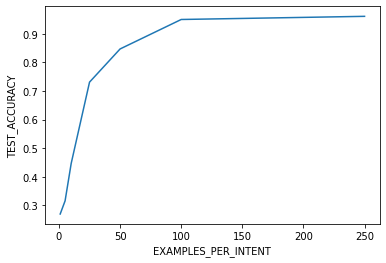

In [ ]:
# A Plot of the final test accuracies as a function of EXAMPLES_PER_INTENT.
import seaborn as sns
for accuracy in test_accuracies:
  test_accuracies[accuracy] = np.round(test_accuracies[accuracy],3)

test_accuracies

ax = sns.lineplot(
    data=test_accuracies,
    x=list(test_accuracies.keys()), y=list(test_accuracies.values()),
    markers=True)
ax.set(xlabel='EXAMPLES_PER_INTENT', ylabel='TEST_ACCURACY')
plt.show()

**What do you notice about this curve? What does it tell us about how much training data we may need to train a high-performing intent recognition model?**

- From the curve It was noticed that the test accuracy increases as the examples per intent increases.
- This means in order to train a high-performing intent recognition model, There must be sufficient examples per intent (class).
- More data; the better model performance on the test set.

**Do you think this pattern would apply to other intent recognition datasets? Why or why not?**

- Yes, This pattern will apply to other intent recognition datasets.
- This is because the higher the quantity of quality data per intent (class) is provided, the better the model is at accurately distinguishing between intents.